In [1]:
import pandas as pd
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'..')
from src.data.etl import *
from src.model.train_model import *
from src.analysis.analysis import *

In [2]:
print(sys.path)

['..', '/home/shw276/template/notebooks', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/home/shw276/.local/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/jsplice-1.1.0-py3.7.egg', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/home/shw276/.ipython']


# Epidemiology Model 


# Data 
- 1. COVID-19 US cases: Directly read data from JHU github repo.
- 2. Mobility Data provided by Apple for each county in the U.S.


In [3]:
us_confirmed_df,us_death_df,global_recover_df,mobility = retrieve_data()
display(us_confirmed_df.head())
display(us_death_df.head())
display(global_recover_df.head())
display(mobility.head())

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,2/13/21
0,84001001,US,USA,840,01001,Autauga,Alabama,US,32.539527,-86.644082,...,5811,5824,5856,5869,5881,5910,5930,5970,5984,6002
1,84001003,US,USA,840,01003,Baldwin,Alabama,US,30.727750,-87.722071,...,18494,18568,18668,18723,18763,18824,18888,18960,18994,19051
2,84001005,US,USA,840,01005,Barbour,Alabama,US,31.868263,-85.387129,...,1989,1994,2002,2008,2008,2019,2024,2030,2036,2040
3,84001007,US,USA,840,01007,Bibb,Alabama,US,32.996421,-87.125115,...,2327,2331,2334,2339,2346,2362,2368,2377,2385,2393
4,84001009,US,USA,840,01009,Blount,Alabama,US,33.982109,-86.567906,...,5842,5871,5908,5915,5920,5929,5937,5955,5953,5957


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,2/13/21
0,84001001,US,USA,840,01001,Autauga,Alabama,US,32.539527,-86.644082,...,74,76,77,77,77,77,79,81,84,84
1,84001003,US,USA,840,01003,Baldwin,Alabama,US,30.727750,-87.722071,...,233,234,227,227,227,228,239,240,251,252
2,84001005,US,USA,840,01005,Barbour,Alabama,US,31.868263,-85.387129,...,43,44,45,45,45,45,46,46,48,48
3,84001007,US,USA,840,01007,Bibb,Alabama,US,32.996421,-87.125115,...,52,52,53,53,53,53,54,54,57,57
4,84001009,US,USA,840,01009,Blount,Alabama,US,33.982109,-86.567906,...,109,111,112,112,112,113,116,116,121,121


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,2/13/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,47995,48018,48027,48041,48042,48109,48133,48279,48390,48392
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,49543,50219,50875,51444,52128,52933,53616,54362,55243,55983
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,74136,74330,74330,74692,74871,75057,75243,75436,75628,75816
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,9395,9444,9492,9533,9610,9674,9732,9781,9833,9868
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,18381,18431,18475,18540,18596,18623,18687,18710,18786,18790


,Country_code,Admin_level,Admin1,Admin2,FIPS,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,...,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21
0,US,1,Alabama,NaN,00001,0.011796,0.018045,0.195074,0.016354,0.181694,...,0.016644,0.015782,0.017230,0.014709,0.010420,0.023426,0.003288,0.014917,0.017855,0.030373
1,US,2,Alabama,Autauga County,01001,0.010175,0.025468,0.258896,0.022481,0.243549,...,0.021629,0.020355,0.022412,0.014242,0.009760,0.031027,0.004209,0.019923,0.023283,0.039731
2,US,2,Alabama,Baldwin County,01003,0.013860,0.020959,0.213163,0.017559,0.205228,...,0.016944,0.015772,0.016413,0.014487,0.011433,0.023547,0.003253,0.013970,0.018017,0.028281
3,US,2,Alabama,Barbour County,01005,0.011820,0.017347,0.170692,0.010406,0.135686,...,0.015869,0.016005,0.016411,0.010021,0.011621,0.023221,0.002836,0.013860,0.019866,0.029945
4,US,2,Alabama,Bibb County,01007,0.018460,0.040510,0.456464,0.037057,0.450207,...,0.029679,0.026941,0.034172,0.025996,0.016584,0.042922,0.005418,0.026061,0.031010,0.054604


In [4]:
df_list = us_confirmed_df,us_death_df,global_recover_df,mobility

In [5]:
# Getting the Susceptible, Infected, Removed, and Population of US from 30 - 70 days into the pandemic
#get_country(30,40,df_list)


# Key variables of Epidemiology Model
- I, the number of infected, is in the `us_comfirmed`
- S, susceptible to COVID-19, is in `us_population` - `us_confirmed`, denoted as `us_susceptible`
- R, removed, is the sum of recovered and deceased. 
- N, population

## Parameters
- Beta: the infection rate
- D: number of days a patient can stay infected

## Goal
- With existing knowledge of I,S,R,and N, use gradient descent to figure out $\theta$ = ($\beta$, D)

# Methods
## Gradient Descent to solve for $\beta$ and $\frac{1}{D}$

Given: 
$\begin{align*}
  &\xi = \frac{1}{D} \\
  &f_s(I_n,N,S_n) = -\beta\left(\frac{I_n}{N}\right) S_n, \\
  &f_I(I_n,N,S_n) = - I\xi + \beta\left(\frac{I_n}{N}\right) S_n,  \\
  &f_R(I_n) = I_n\xi, \\
  &h=1
\end{align*}
$

Plug the above values into
$\frac{1}{N} \sum_{n=1}^N \nabla_{\theta} \left( \left({\frac{s(n+1)-s(n)}{h} - f_s(s(n), I(n), R(n);\theta)}\right)^2
+ \left({\frac{I(n+1)-I(n)}{h} - f_I(s(n), I(n), R(n;\theta)}\right)^2 + \dots \right)$

To calculate the above the term, we need to use __chain rule__ to differentiate with respect to $\beta$ and $\xi$

$\nabla_{\beta} = 2 \cdot \left(\frac{S_{n+1} - S_{n}}{h} - \left(-\beta S_n  \frac{I_n}{N}\right) \right) \cdot \left(S_n \cdot \frac{I_n}{N}\right) + 2 \cdot \left(\frac{I_{n+1} - I_{n}}{h}  - \left( -\xi_k I_n + \beta_k \frac{I_n}{N} S_n \right)\right) \cdot \left( -S_n \cdot \frac{I_n}{N}\right)$

$\nabla_{\xi} = 2 \cdot \left(\frac{I_{n+1} - I_{n}}{h}  + \left(I_n\xi_k - \beta_k \frac{I_n}{N}S_n\right) \right) \cdot \left(I_n\right) + 2 \cdot \left(\frac{R_{n+1} - R_{n}}{h} - I_n\xi_k\right) \cdot \left( -I_n\right)$



## Tuning
First initialize $\theta$ at $\beta = 0.2 $ and $\xi = 0.1$


Then, at each iteration update $\beta$ and $\xi$ according to the rules below


$\beta_{k+1} = \beta_k - h_G \partial_\beta L(\theta|s(1),\dots,s(N)),$


$
\xi_{k+1} = \xi_k - h_G \partial_\xi L(\theta|s(1),\dots,s(N)).$
 where $h_G = 0.001$
 


 ## Tuning learning rate
 $\nabla_{\beta} = 2 \cdot \left(\frac{S_{n+1} - S_{n}}{h} - \left(-\beta_{k} S_n  \frac{I_n}{N}\right) \right) \cdot \left(S_n \cdot \frac{I_n}{N}\right) + 2 \cdot \left(\frac{I_{n+1} - I_{n}}{h}  - \left( -\xi_k I_n + \beta_k \frac{I_n}{N} S_n \right)\right) \cdot \left( -S_n \cdot \frac{I_n}{N}\right)$

$\nabla_{\xi} = 2 \cdot \left(\frac{I_{n+1} - I_{n}}{h}  + \left(I_n\xi_k - \beta_k \frac{I_n}{N}S_n\right) \right) \cdot \left(I_n\right) + 2 \cdot \left(\frac{R_{n+1} - R_{n}}{h} - I_n\xi_k\right) \cdot \left( -I_n\right)$


 The Hessian matrix will look like the following:
$ \begin{bmatrix}
 \frac{\partial \nabla_{\beta}}{\partial \beta} &  \frac{\partial \nabla_{\xi}}{\partial_{\beta}}\\
\frac{\partial \nabla_{\beta}}{\partial_{\xi}} & \frac{\partial \nabla_{\xi}}{\partial \xi}
\end{bmatrix}$

We can calculate the hessian matrix given s,i arrays and population 

 $
 \begin{aligned}
 \frac{\partial \nabla_{\beta}}{\partial \beta} &= \frac{1}{N} \sum_{n=1}^N \left(2\cdot \left(S_{n}\cdot \frac{I_{n}}{N}\right)^2 + 2\cdot \left(S_{n} \cdot \frac{I_{n}}{N}\right) ^2\right) \\
 &= \frac{1}{N} \sum_{n=1}^N \left(4\cdot \left(S_{n}\cdot \frac{I_{n}}{N}\right)^2\right) 
  \end{aligned}$
 
  $\begin{aligned}
  \frac{\partial \nabla_{\xi}}{\partial \xi} &= \frac{1}{N} \sum_{n=1}^N \left(2\cdot I_{n} ^2 + 2\cdot I_{n} ^2\right) \\
  &= \frac{1}{N} \sum_{n=1}^N  4\cdot I_{n} ^2
  \end{aligned}$
  
   $
 \begin{aligned}
 \frac{\partial \nabla_{\xi}}{\partial_{\beta}} &=  \frac{1}{N} \sum_{n=1}^N -2 \cdot S_{n}\cdot \frac{I_{n}^2}{N} \\
 & = \frac{\partial \nabla_{\beta}}{\partial_{\xi}}
  \end{aligned}$
  
  

  
We then use numpy.lin.eg to get the eigen value of the hessian matrix

In [5]:

s,i,r,p = get_country(30,40,df_list)
learning_rate = tune_learning_rate(s,i,r,p)
print(learning_rate) #Calculate the learning rate from hessian matrix

1.1156462185756376e-11


In [6]:
calculate(s,i,r,p,learning_rate,p) #Outputs the Beta, and D

(0.1832774203773528, 101.48075520477383)

0.1832774203773528 101.48075520477383


'us.png'

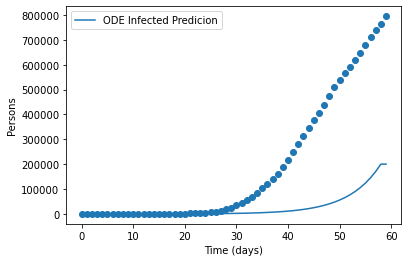

In [7]:
beta,d = calculate(s,i,r,p,learning_rate,p)
s,i,r,p = get_country(30,60,df_list)

print(beta,d)
length = 60 #predicting 20 more days 
draw_ODE_from_data("us.png",s,i,r,p,beta,d,length,int_steps=1)

0.17522671120713582 399.8722628878253


'california.png'

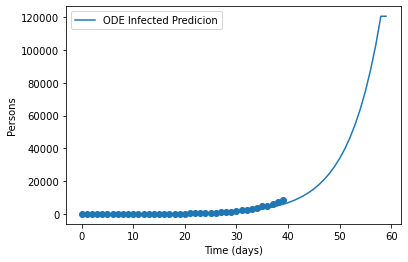

In [8]:
s,i,r,p = get_state(30,40,df_list,"California")
learning_rate = tune_learning_rate(s,i,r,p)
beta,d = calculate(s,i,r,p,learning_rate,p)
print(beta,d)
length = 60 #predicting 20 more days 
draw_ODE_from_data("california.png",s,i,r,p,beta,d,length,int_steps=1)

0.1522507750708867 797.6176130395337


'sd.png'

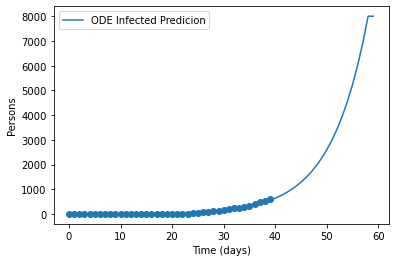

In [9]:
s,i,r,p = get_county(30,40,df_list,"06073")
learning_rate = tune_learning_rate(s,i,r,p)
beta,d = calculate(s,i,r,p,learning_rate,p)
print(beta,d)
length = 60 #predicting 20 more days 
draw_ODE_from_data("sd.png",s,i,r,p,beta,d,length,int_steps=1)

# Use Geographical Information And Mobility Data to Predict County Infection
Each county is never in total isolation from other counties. There is always traffic going in and out of the counties at county borders. So it is necessary to account for the relative mobility, what are the neighboring counties and what are the infection numbers of the neighboring counties to predict infection numbers for each county.

We will use spatial dynamics to predict case numbers for the next day based on the case numbers of the previous day (and of course, geographical information and mobility score)

$\begin{align*}
  \frac{\partial S(x,t)}{\partial t} &= -\beta\left(\frac{I(x,t)}{N}\right) S(x,t) + M(x,t) \Delta_x S(x,t), \\
  \frac{\partial I(x,t)}{\partial t} &= - \frac{I(x,t)}{D} + \beta\left(\frac{I(x,t)}{N}\right) S(x,t) + M(x,t) \Delta_x I(x,t),  \\
  \frac{\partial R(x,t)}{\partial t} &= \frac{I(x,t)}{D} + M(x,t) \Delta_x R(x,t).
\end{align*}$

The complete dynamics looks like:
$\begin{multline*}
I(x_1,y_2,t_1) = I(x_1,y_2,t_2) 
- \frac{I(x_1,y_2,t_2)}{D} + \beta\left(\frac{I(x_1,y_2,t_2)}{N}\right) S(x_1,y_2,t_2)  \\
+ M * { I(x_0,y_2,t_2) + I(x_2,y_2,t_2) - 2 I(x_1,y_2,t_2)  + I(x_1,y_1,t_2) + I(x_1,y_3,t_2) - 2 I(x_1,y_2,t_2) }.
\end{multline*}
$
Where M stands for Mobility index (ranging from 0 to 1, and 1 means the most active), I stands for Infection, S stands for Suspected, t_2 stands for the previous day, and t_1 stands for the day we want to predict
$\begin{align}
\frac{\partial I(x,t)}{\partial t} &= - \frac{I(x,t)}{D} + \beta\left(\frac{I(x,t)}{N}\right) S(x,t) + M(x,t) \Delta_x I(x,t)\end{align}$


The gradient would be calculated as $
\nabla_x I(x,t) |_{(x^1, x^2)} \approx
\left( \begin{array}{c}
    \frac{I(x^1,t) - I(x^2,t)}{x^1_1 - x^2_1} 
    \frac{I(x^1,t) - I(x^2,t)}{x^1_2 - x^2_2}
\end{array}
\right)
$

for two neighboring points: $x^1$, $x^2$.
\begin{align}
\Delta_x I(x,t) |_{(x^1, x^2, x^3)} \approx
    \frac{ \partial_{x_1} I(x,t) |_{(x^1, x^2)} - \partial_{x_1} I(x,t) |_{(x^2, x^3)} }{ x^1_1 - x^3_1 } 
    + \frac{ \partial_{x_2} I(x,t) |_{(x^1, x^2)} - \partial_{x_2} I(x,t) |_{(x^2, x^3)} }{ x^1_2 - x^3_2 } \\
    + \frac{ \partial_{x_1} I(x,t) |_{(x^4, x^2)} - \partial_{x_1} I(x,t) |_{(x^2, x^5)} }{ x^4_1 - x^5_1 } 
    + \frac{ \partial_{x_2} I(x,t) |_{(x^4, x^2)} - \partial_{x_2} I(x,t) |_{(x^2, x^5)} }{ x^4_2 - x^5_2 } 
\end{align}
If $x$ is a uniform mesh, then at $x_{(2,2)}$,
\begin{align}
\Delta_x I &= \frac{ (I(x_{(1,2)} ,t ) - I( x_{(2,2)} ,t ) - ( I(x_{2,2},t) - I(x_{(3,2)},t) ) }{\Delta x^2} + \frac{I(x_{(2,1)},t) + I(x_{(2,3)},t) - 2 I(x_{2,2},t) }{\Delta x^2} \\
&= \frac{I(x_{west},t) + I(x_{east},t) - 2 I(x_{center},t) }{\Delta x^2} + \frac{I(x_{south},t) + I(x_{north},t) - 2 I(x_{center},t) }{\Delta x^2}.
\end{align}


$ \Delta x$ can be calulcated as $x_{west,lat} - x_{east,lat}$

# Example: Southern California
We performed a prediction test for southern california. Most counties have error rate less than 25%. 

In [10]:
fips_neighbor_dict = generate_sc_neighbor_dictionary(us_confirmed_df)
d1 = calculate_i_t1("1/21/21",fips_neighbor_dict,us_confirmed_df,.2,14,us_death_df,mobility,n=5)
li = list(d1.keys())
interpret_dictionary_FIP(d1,us_confirmed_df)

{'San Bernardino, California': 286193.21586901945,
 'Kern, California': 100541.27725743107,
 'San Luis Obispo, California': 41536.635744655934,
 'Santa Barbara, California': 29246.905394403082,
 'Ventura, California': 76086.44653333146,
 'Los Angeles, California': 1158533.813474694,
 'Orange, California': 273922.99980504176,
 'Riverside, California': 276036.2223509271,
 'San Diego, California': -7578765.442320127,
 'Imperial, California': 610863.9528026284}

In [11]:
fips_neighbor_dict = generate_sc_neighbor_dictionary(us_confirmed_df)

d1 = calculate_i_t1("1/21/21",fips_neighbor_dict,us_confirmed_df,.2,14,us_death_df,mobility,n=5)

check_prediction(li,d1,us_confirmed_df,"1/22/21")
    

../src/model/train_model.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["predicted"] = df["FIPS"].replace(prediction_dic).apply(lambda x:int(x))
../src/model/train_model.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["percent_difference"] = (df["predicted"] - df[date]) / df[date]


,Admin2,1/22/21,predicted,percent_difference
207,Imperial,25509,610863,22.946960
209,Kern,88399,100541,0.137354
213,Los Angeles,1054802,1158533,0.098342
224,Orange,237198,273922,0.154824
228,Riverside,258532,276036,0.067705
231,San Bernardino,261199,286193,0.095689
232,San Diego,222578,-7578765,-35.049929
235,San Luis Obispo,16437,41536,1.526982
237,Santa Barbara,25986,29246,0.125452
252,Ventura,63995,76086,0.188937


<img src="https://i.pinimg.com/originals/16/57/c3/1657c35c5e8c8e87289f00b4869c2889.png">

# Result & Discussion
From the map above, we can see that the counties we have really "inaccurate" predictions are San Luis Obispo, Imperial and San Diego counties, which are all in the corners of all the counties we took into consideration. The missing data for neighboring counties for the counties on edges/corners can explain away some of the inaccuracy in predictions for these counties. 
